In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input, LayerNormalization, Dropout, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import MultiHeadAttention

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.regularizers import l2
from time import time

In [2]:
dataset_path = '/kaggle/input/thien-uu/Thien_uu'

garbage_types = os.listdir(dataset_path)

all_dimensions_set = set()

for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpeg', 'jpg'))]

        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

if len(all_dimensions_set) == 1:
    width, height, channels = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

Negative folder contains 985 images.
Thien_uu-8 folder contains 1021 images.

The images in the dataset have different dimensions or color channels.


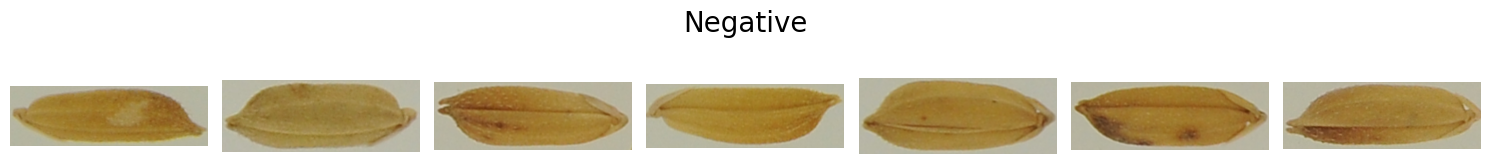

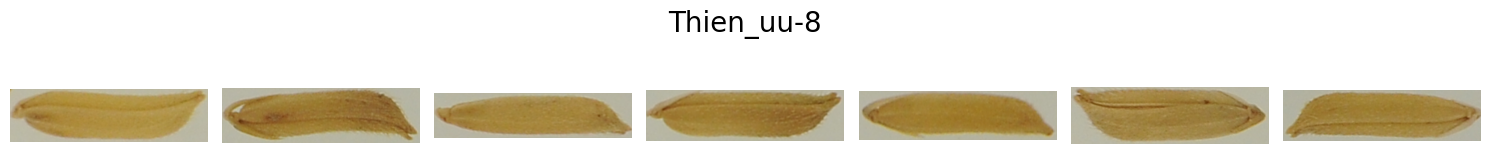

In [3]:
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Kiểm tra xem mục hiện tại có phải là thư mục không
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('png', 'jpeg', 'jpg'))]

        image_files = image_files[:7]

        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)

In [4]:
data = []

for garbage_type in garbage_types:
    for file in os.listdir(os.path.join(dataset_path, garbage_type)):
        data.append((os.path.join(dataset_path, garbage_type, file), garbage_type))

df = pd.DataFrame(data, columns=['filepath', 'label'])

print(df.head())

train_ratio = 0.55
val_ratio = 0.15
test_ratio = 0.30

temp, val_df = train_test_split(df, test_size=val_ratio, stratify=df['label'])

train_df, test_df = train_test_split(temp, test_size=test_ratio / (train_ratio + test_ratio), stratify=temp['label'])

print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the test set: {len(test_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

                                            filepath     label
0  /kaggle/input/thien-uu/Thien_uu/Negative/DSC64...  Negative
1  /kaggle/input/thien-uu/Thien_uu/Negative/DSC71...  Negative
2  /kaggle/input/thien-uu/Thien_uu/Negative/DSC67...  Negative
3  /kaggle/input/thien-uu/Thien_uu/Negative/DSC64...  Negative
4  /kaggle/input/thien-uu/Thien_uu/Negative/DSC71...  Negative
Number of images in the training set: 1103
Number of images in the test set: 602
Number of images in the validation set: 301


In [5]:
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
x = Flatten()(base_model.output)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# x = Dense(1200, activation='relu', kernel_regularizer=l2(0.01))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [7]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [8]:
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=30, verbose=1, mode='min'
)

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6, verbose=1, mode='min'
# )

csv_logger = CSVLogger('training_log.csv')

callbacks_list = [checkpoint, early_stopping, csv_logger]

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224), 
    batch_size=32,
    class_mode='binary'  
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 1103 validated image filenames belonging to 2 classes.
Found 602 validated image filenames belonging to 2 classes.
Found 301 validated image filenames belonging to 2 classes.


In [10]:
start_time = time()

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=200,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

end_time = time()
training_time = end_time - start_time

print(f"Total training time: {training_time // 60} minutes and {training_time % 60} seconds")

Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725868505.187676     112 service.cc:145] XLA service 0x7e4464087330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725868505.187745     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 2/34 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6562 - loss: 1.4727  

I0000 00:00:1725868519.257976     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


34/34 ━━━━━━━━━━━━━━━━━━━━ 51s 693ms/step - accuracy: 0.8542 - loss: 0.8302 - val_accuracy: 0.5417 - val_loss: 2.9799
Epoch 2/200
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9688 - loss: 0.4439

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.9688 - loss: 0.4439 - val_accuracy: 0.4615 - val_loss: 3.1645
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 0.9608 - loss: 0.4073 - val_accuracy: 0.7951 - val_loss: 0.6977
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.3406 - val_accuracy: 0.7692 - val_loss: 0.5236
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9735 - loss: 0.2776 - val_accuracy: 0.9653 - val_loss: 0.2427
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.2459 - val_accuracy: 0.9231 - val_loss: 0.2206
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.9843 - loss: 0.2105 - val_accuracy: 0.9167 - val_loss: 0.3014
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1714 - val_accuracy: 0.9231 - val_loss: 0.2406
Epoch 9/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9912 - loss: 0.1604 - val_accuracy: 0.9757 - val_los

In [13]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=val_generator.samples // val_generator.batch_size)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9098 - loss: 0.3773
Validation Loss: 0.34856611490249634
Validation Accuracy: 0.9097222089767456
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9473 - loss: 0.2520
Test Loss: 0.2383061796426773
Test Accuracy: 0.9444444179534912


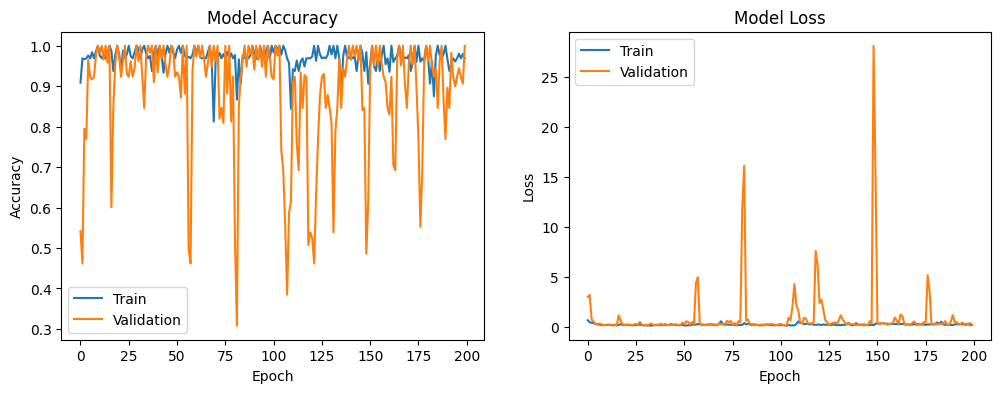

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()